In [1]:
import pandas as pd
import numpy as np
import scipy as sc
from scipy import stats
import matplotlib.pyplot as plt
import statsmodels.api as sm
from statsmodels.tsa.stattools import adfuller
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from itertools import product
import datetime

import folium
import branca.colormap as cm

import warnings
warnings.simplefilter(action='ignore')

### 1. Подготовка данных
Загрузим регионы, в которых число поездок не меньше 5 (мы получали их в одном из предыдущих ноутбуков).

In [19]:
name_regions = pd.read_csv("data/nonzero_regions.csv").iloc[:,1]
print(name_regions)

0      1075
1      1076
2      1077
3      1125
4      1126
       ... 
97     2068
98     2069
99     2118
100    2119
101    2168
Name: 0, Length: 102, dtype: int64


In [8]:
df_3=pd.read_csv("data/aggs/taxi_2016_03.csv")
df_4=pd.read_csv("data/aggs/taxi_2016_04.csv")
df_2=pd.read_csv("data/aggs/taxi_2016_02.csv")
df_1=pd.read_csv("data/aggs/taxi_2016_01.csv")
data=pd.concat([ df_1,df_2,df_3,df_4], axis=0)

data.rename(columns={'Unnamed: 0':'time'}, inplace=True)
data.index=data.time
df=data.iloc[:,name_regions]
df.head()

,1075,1076,1077,1125,1126,1127,1128,1129,1130,1131,...,1630,1684,1733,1734,1783,2068,2069,2118,2119,2168
time,,,,,,,,,,,,,,,,,,,,,
2016-01-01 00:00:00,80.0,144.0,50.0,77.0,319.0,402.0,531.0,617.0,846.0,267.0,...,12.0,0.0,2.0,44.0,5.0,41.0,4.0,70.0,7.0,66.0
2016-01-01 01:00:00,91.0,211.0,49.0,134.0,404.0,420.0,370.0,453.0,594.0,224.0,...,29.0,0.0,5.0,2.0,2.0,4.0,0.0,47.0,1.0,29.0
2016-01-01 02:00:00,90.0,146.0,23.0,110.0,393.0,425.0,313.0,366.0,377.0,138.0,...,47.0,0.0,3.0,0.0,4.0,0.0,0.0,69.0,1.0,14.0
2016-01-01 03:00:00,32.0,87.0,16.0,62.0,252.0,399.0,324.0,309.0,327.0,166.0,...,46.0,0.0,2.0,4.0,5.0,1.0,0.0,21.0,0.0,9.0
2016-01-01 04:00:00,24.0,43.0,10.0,53.0,145.0,254.0,264.0,333.0,318.0,145.0,...,43.0,0.0,0.0,1.0,1.0,0.0,0.0,26.0,1.0,6.0


### 2. Кластеризация
Нам нужно будет построить модели для всех этих регионов. Для экономии времени при подборе параметров, кластеризуем наши 102 региона, найдем их центры (будем смотреть реальные регионы, которые ближе всего к геометрическому центру). Перед кластеризацией следует привести признаки к одному масштабу и транспонировать, для того чтобы кластеризация проводилась по районам, а не по времени.

In [9]:
sc=StandardScaler()
df_s=pd.DataFrame(sc.fit_transform(X=np.array(df)), columns=df.columns)
df_t = df_s.T
df_t

,0,1,2,3,4,5,6,7,8,9,...,2894,2895,2896,2897,2898,2899,2900,2901,2902,2903
1075,0.534333,0.823393,0.797115,-0.727022,-0.937247,-1.278864,-1.383977,-1.331421,-1.094917,-0.989804,...,2.058469,2.242417,2.689147,2.163582,2.557756,1.611740,1.243845,0.823393,1.059897,0.849671
1076,0.178299,1.005639,0.202995,-0.525558,-1.068886,-1.377595,-1.291156,-1.291156,-1.278808,-1.130628,...,2.326913,2.092295,1.042684,1.289651,1.153819,0.980942,0.968594,0.314131,-0.402074,-0.142759
1077,-0.565388,-0.582598,-1.030077,-1.150552,-1.253817,-1.339870,-1.374292,-1.253817,-1.271027,-1.133342,...,1.052420,1.104052,0.501677,0.484466,0.708206,1.069631,0.277938,0.432834,0.036988,-0.341648
1125,0.271055,1.673853,1.083201,-0.098103,-0.319598,-1.205576,-1.205576,-1.254797,-1.131744,-0.910250,...,0.615602,0.615602,0.221834,0.763265,1.107812,0.861707,1.009370,1.206254,0.837096,0.492549
1126,1.423610,2.292927,2.180427,0.738384,-0.355932,-1.307067,-1.440022,-1.409340,-1.122977,-1.153658,...,1.116792,1.096338,0.861111,1.556564,1.628155,1.689519,1.127020,1.413383,0.380430,1.065656
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2068,-0.786766,-1.423829,-1.492701,-1.475483,-1.492701,-0.907291,-0.907291,-0.425189,-0.666240,-0.976163,...,1.503219,1.193296,1.089989,1.709834,0.745630,0.917809,0.556233,0.728412,0.780066,0.814502
2069,-0.681902,-1.172000,-1.172000,-1.172000,-1.172000,-0.804427,-0.559377,0.175771,0.053246,-1.172000,...,0.420820,0.543344,0.665869,0.910918,-0.191803,-0.559377,0.175771,0.788394,1.401017,0.053246
2118,-0.821275,-1.125258,-0.834492,-1.468890,-1.402807,-0.781625,-0.556942,-0.781625,-1.045958,-1.019525,...,0.830805,1.095138,0.962972,1.266954,0.288923,0.341789,1.319821,0.341789,0.870455,0.645772
2119,-0.855714,-1.089383,-1.089383,-1.128328,-1.089383,-1.089383,-0.816769,-0.699935,-0.855714,-0.466266,...,1.558868,1.831482,0.585246,3.077717,0.546301,1.169419,0.818915,2.026206,-0.232596,1.753592


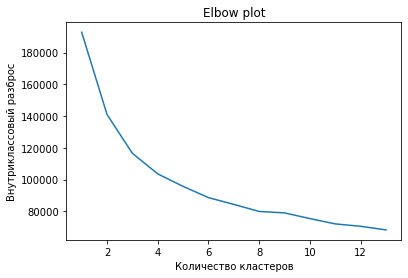

In [6]:
# Воспользуемся методом локтя для определения числа кластеров
inertia = []
num_of_clusters = np.arange(1,14)
for i in num_of_clusters:
    km = KMeans(n_clusters=i, max_iter=100, random_state=100)
    km.fit(df_t)    
    inertia.append(km.inertia_)
    
plt.plot(num_of_clusters, inertia)
plt.title('Elbow plot')
plt.xlabel('Количество кластеров')
plt.ylabel('Внутриклассовый разброс')
plt.show()

Пускай число кластеров будет равно 6.

In [10]:
n_clust = 6
km = KMeans(n_clusters=n_clust, max_iter=100, random_state=100)
km.fit(df_t)
km.labels_

array([4, 1, 1, 4, 4, 4, 4, 0, 0, 4, 1, 3, 3, 3, 3, 0, 0, 0, 4, 4, 1, 3,
       1, 1, 0, 0, 0, 3, 3, 0, 0, 4, 4, 4, 4, 4, 1, 1, 0, 0, 0, 0, 1, 1,
       4, 4, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 4, 3, 0, 0, 0, 0,
       4, 1, 1, 1, 1, 3, 3, 3, 3, 0, 3, 1, 3, 3, 3, 3, 3, 3, 3, 5, 5, 5,
       5, 0, 0, 5, 5, 2, 2, 2, 2, 2, 2, 2, 2, 2])

In [11]:
reg_clusters = {}
for j,i in enumerate(df_t.index):
    reg_clusters[i] = km.labels_[j]

In [13]:
reg_0 = [i for i, j in reg_clusters.items() if j == 0 ]
reg_1 = [i for i, j in reg_clusters.items() if j == 1 ]
reg_2 = [i for i, j in reg_clusters.items() if j == 2 ]
reg_3 = [i for i, j in reg_clusters.items() if j == 3 ]
reg_4 = [i for i, j in reg_clusters.items() if j == 4 ]
reg_5 = [i for i, j in reg_clusters.items() if j == 5 ]

In [32]:
print('0 кластер: len {}\n1 кластер: len {}\n2 кластер: len {}\n3 кластер: len {}\n4 кластер: len {}\n5 кластер: len {}\n'.format(len(reg_0), len(reg_1), len(reg_2), len(reg_3), len(reg_4), len(reg_5)))

0 кластер: len 23
1 кластер: len 27
2 кластер: len 9
3 кластер: len 20
4 кластер: len 17
5 кластер: len 6



Отобразим эти кластеры на интерактивной карте:

In [11]:
regions = pd.read_csv('data/regions.csv', sep=';')

NY_border={'W': -74.25559, 'E': -73.70001, 'S': 40.49612, 'N': 40.91553}
cx, cy =  (NY_border['S'] + NY_border['N']) / 2, (NY_border['W'] + NY_border['E']) / 2

In [ ]:
colormap = cm.LinearColormap(colors=['darkolivegreen', 'green', 'yellow', 'orange', 'red', 'maroon'],
                                          index = np.round(np.linspace(0, 5, 6)),
                                          vmin = 0, vmax = 6)

m = folium.Map(location=[cx, cy], zoom_start = 11)

for i in map(int, reg_0):
    folium.Rectangle(bounds=list([(regions['south'].iloc[i],regions['west'].iloc[i]), 
     (regions['north'].iloc[i],regions['east'].iloc[i])]), 
      color=0, fill=True, fill_color=colormap(0), fill_opacity=0.6).add_to(m)

for i in map(int, reg_1):
    folium.Rectangle(bounds=list([(regions['south'].iloc[i],regions['west'].iloc[i]), 
     (regions['north'].iloc[i],regions['east'].iloc[i])]), 
      color=0, fill=True, fill_color=colormap(1), fill_opacity=0.6).add_to(m)

for i in map(int, reg_2):
    folium.Rectangle(bounds=list([(regions['south'].iloc[i],regions['west'].iloc[i]), 
     (regions['north'].iloc[i],regions['east'].iloc[i])]), 
      color=0, fill=True, fill_color=colormap(2), fill_opacity=0.6).add_to(m)

for i in map(int, reg_3):
    folium.Rectangle(bounds=list([(regions['south'].iloc[i],regions['west'].iloc[i]), 
     (regions['north'].iloc[i],regions['east'].iloc[i])]), 
      color=0, fill=True, fill_color=colormap(3), fill_opacity=0.6).add_to(m)

for i in map(int, reg_4):
    folium.Rectangle(bounds=list([(regions['south'].iloc[i],regions['west'].iloc[i]), 
     (regions['north'].iloc[i],regions['east'].iloc[i])]), 
      color=0, fill=True, fill_color=colormap(4), fill_opacity=0.6).add_to(m)

for i in map(int, reg_5):
    folium.Rectangle(bounds=list([(regions['south'].iloc[i],regions['west'].iloc[i]), 
     (regions['north'].iloc[i],regions['east'].iloc[i])]), 
      color=0, fill=True, fill_color=colormap(5), fill_opacity=0.6).add_to(m)
    
colormap.caption = 'Clusters'
colormap.add_to(m)
m

Посмотрим на графики временных рядов внутри одного кластера (например, 0 кластера):

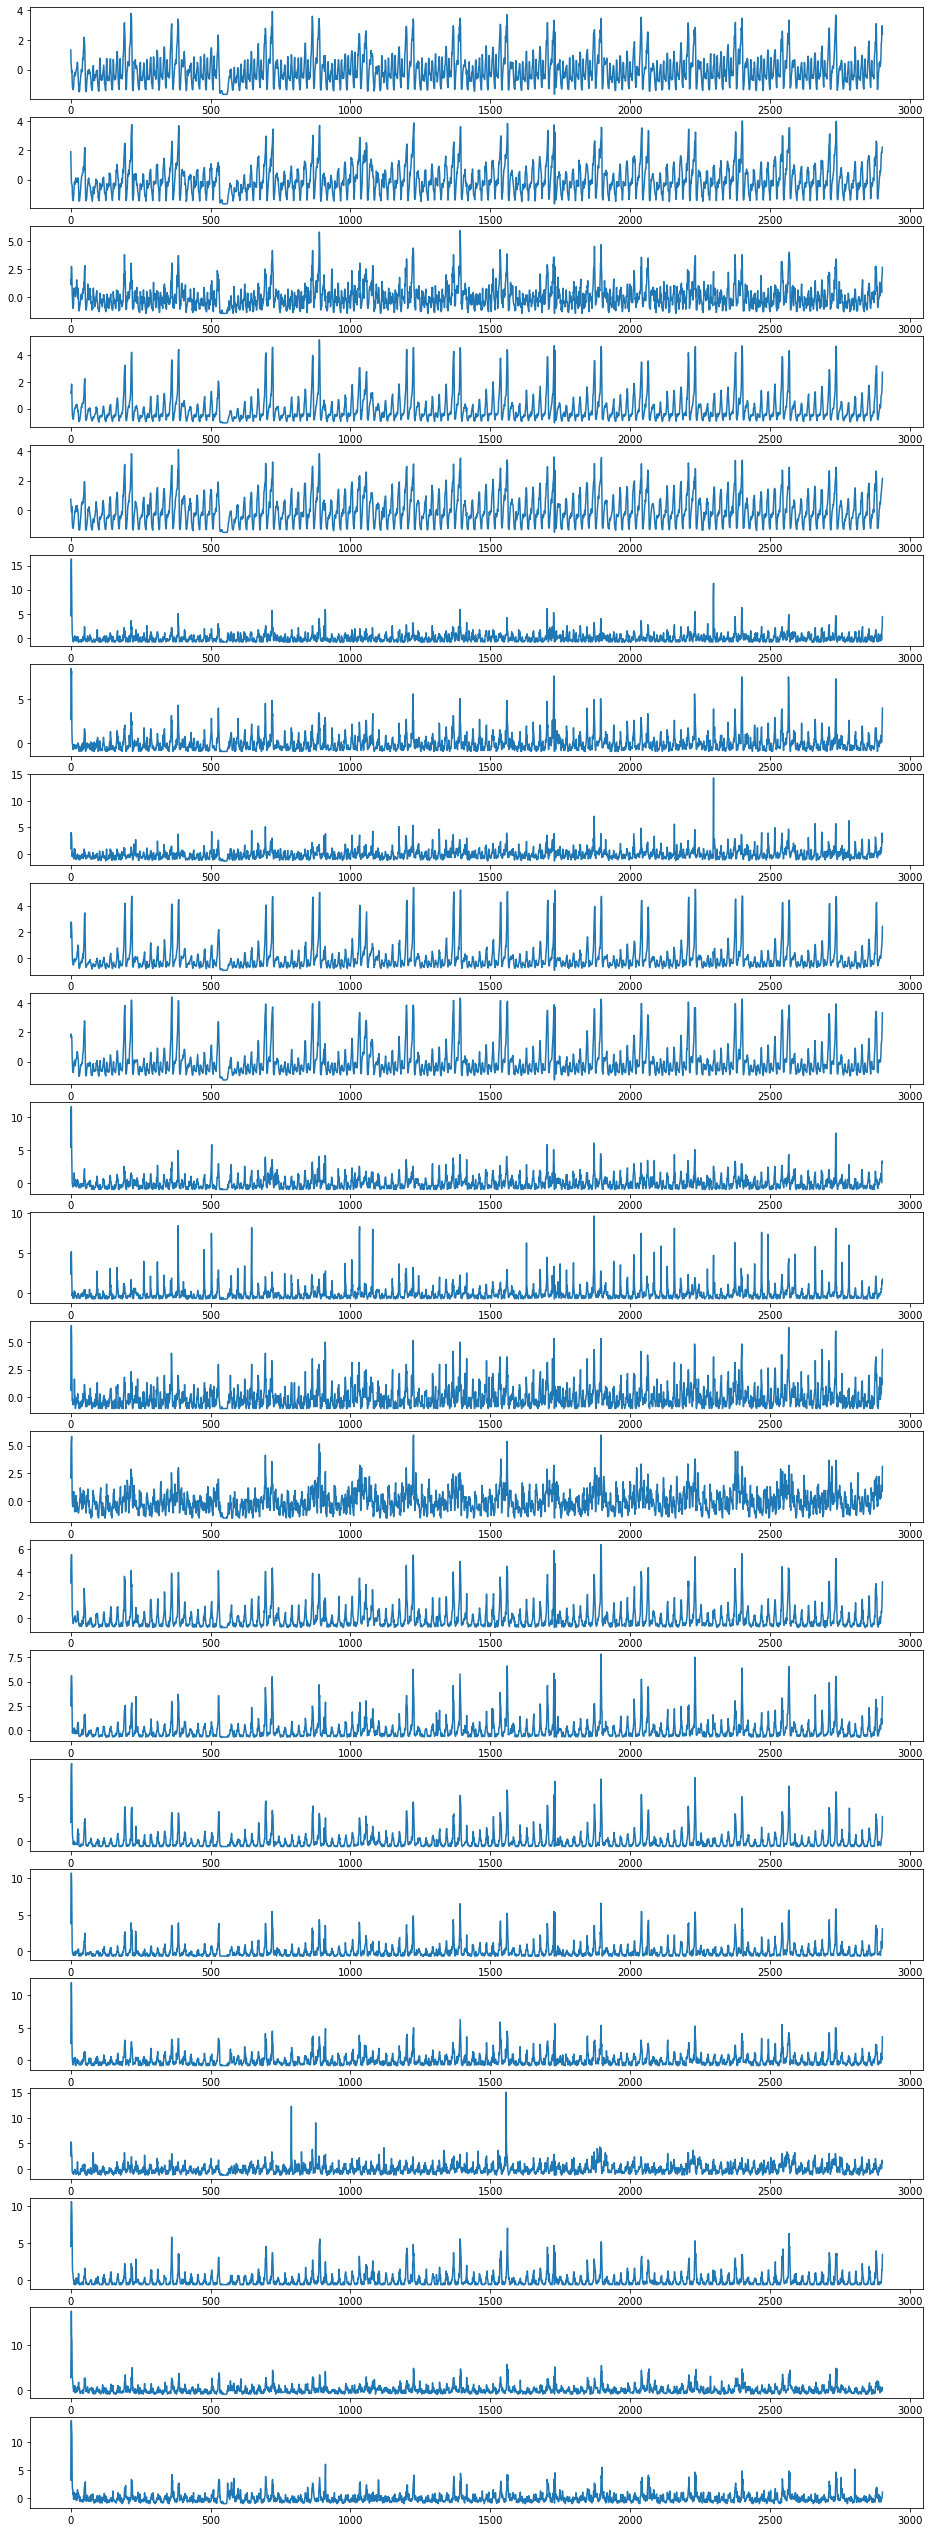

In [13]:
plt.figure(figsize=(16,len(reg_0)*2))
for (reg_num, i) in  zip(reg_0,range(len(reg_0))) :
    plt.subplot(len(reg_0),1,i+1)
    plt.plot(df_s[str(reg_num)], color='tab:blue')
plt.show()

Посмотримм еще на один кластер (например, 6):

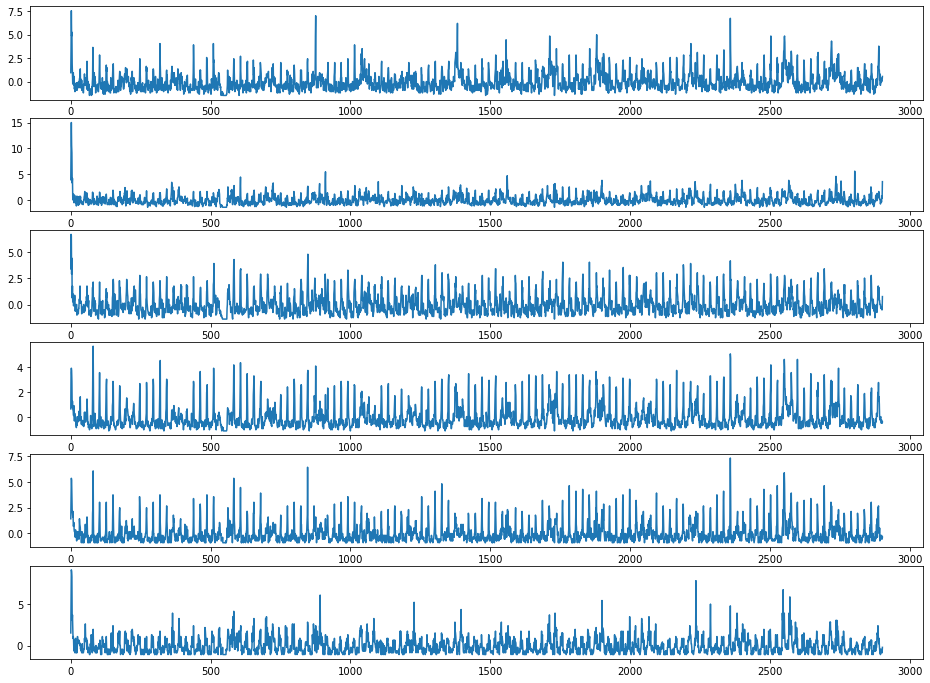

In [15]:
plt.figure(figsize=(16,len(reg_5)*2))
for (reg_num, i) in  zip(reg_5,range(len(reg_5))) :
    plt.subplot(len(reg_5),1,i+1)
    plt.plot(df_s[str(reg_num)], color='tab:blue')
plt.show()

Найдем регионы, которые ближе всего находятся к геометрическим центрам кластеров:

In [33]:
from sklearn.metrics import pairwise_distances_argmin_min
closest, _ = pairwise_distances_argmin_min(km.cluster_centers_, df_t)
inds=df_t.index[closest]
inds

Index(['1326', '1333', '2068', '1387', '1180', '1530'], dtype='object')

In [34]:
clusters= []
for i in inds:
    clust = df[[i]]
    clust.index = pd.to_datetime(clust.index)
    clusters.append(clust)

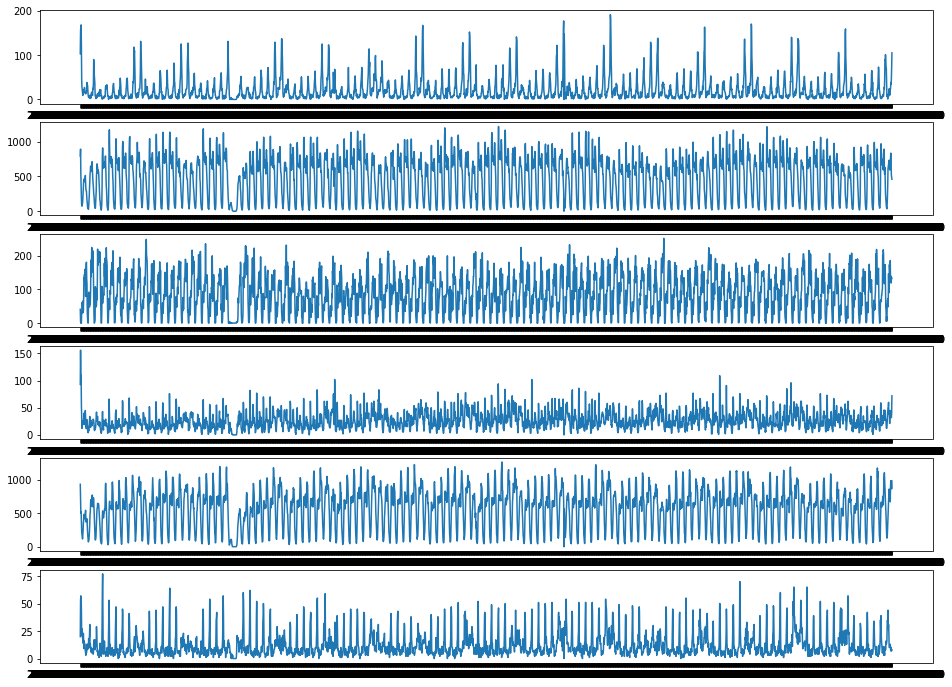

Wall time: 3min 2s


In [42]:
%%time
plt.figure(figsize=(16,12))
for i, j in enumerate(clusters):
    plt.subplot(len(clusters),1,i+1)
    plt.plot(j, color='tab:blue')
plt.show()

### 3. Отбор признаков
Далее займемся отбором экзогенных переменных для выбранных регионов. В прошлом ноутбуке возникла проблема переобучения, поэтому попробуем подобрать наилучший набор признаков. Для этого создадим полный список признаков, а далее будем обучать регрессии на различных поднаборах и сравнивать значения метрик. Поскольку признаков достаточно много, будем делать не полный перебор, а выборочный (число членов ряда Фурье мы трогать не будем). Также нам понадобится дополнительно построить схему кроссвалидации для временных рядов. Несмотря на то, что в задании просят не использовать май месяц, в кроссвалидации мы будем смотреть на него (для обучения у нас всего 4 месяца, а значит кроссвалидацию придется делать с очень небольшим числом фолдов. Можно было бы добавить более старые данные (например, декабрь 2015 года), но в качестве примера воспользуемся маем. Июнь мы не будем учитывать). Отбор призанков будем проводить для каждого района в отдельности. Для начала создадим функцию шаблон для создания датасета:

In [11]:
def get_dataset(region, f_num=55):
    dataset = region.copy()
    
    dataset.index = pd.to_datetime(dataset.index)
    # компоненты ряда Фурье
    w = 168
    t=np.arange(1, dataset.shape[0]+1)
    
    for i in range(1,f_num):
        sin = 's_'+str(i)
        cos = 'c_'+str(i)
        dataset[sin]= np.sin(2*i*np.pi*t/w)
        dataset[cos]= np.cos(2*i*np.pi*t/w)
    
    feats = []
    new_feat_dataset = pd.DataFrame([])
    new_feat_dataset['trend_comp'] = np.arange(1, dataset.shape[0]+1)/(dataset.shape[0]+1)
    feats.append('trend_comp')
    
    new_feat_dataset['trend_2_comp'] = np.arange(1, dataset.shape[0]+1)**2/(dataset.shape[0]+1)
    feats.append('trend_2_comp')
    
    new_feat_dataset['is_weekends'] = np.array((dataset.index.weekday==6)|(dataset.index.weekday==5)).astype(int)
    feats.append('is_weekends')
    
    new_feat_dataset['is_evening'] = np.array((dataset.index.hour == 19)|(dataset.index.hour == 20)).astype(int)
    feats.append('is_evening')
    
    hol_list = ['2016-01-01', '2016-01-18', '2016-02-15', '2016-05-30']
    x = np.array([True if str(i).split()[0] in hol_list else False for i in dataset.index]) 
    new_feat_dataset['is_holidays'] = np.array([True if str(i).split()[0] in hol_list else False for i in dataset.index]).astype(int)
    feats.append('is_holidays')
    
    new_feat_dataset.index = dataset.index
    
    return dataset,new_feat_dataset, feats
    

In [12]:
from itertools import chain, combinations
# функция для полного перебора списка
def powerset(s):
    return chain.from_iterable(combinations(s, r) for r in range(len(s)+1))

In [13]:
def search_feats(dt, fn=55):
    main_data, feat_data, feats = get_dataset(dt, f_num=fn)
    all_metrics = []
    feat_dict = {}
    step = 0
    
    for i in powerset(feats):
        feat_dict[step] = list(i)
        dataset = pd.concat([main_data, feat_data[list(i)]], axis=1)
        
        metrics = cross_val_ts(dataset)
        all_metrics.append(metrics)
        step+=1
        
    return pd.DataFrame(all_metrics, columns=['mse', 'mae', 'r2', 'aic', 'r2_adj']), feat_dict

In [14]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score 

def show_metrics(y_t, y_p):
    return mean_squared_error(y_t, y_p), mean_absolute_error(y_t, y_p), r2_score(y_t, y_p)

In [15]:
def cross_val_ts(data):
    name_reg = data.columns[0]
    mse, mae, r2_sc = 0, 0, 0
    aic, r2adj = 0, 0

    # сначала тренируем на первых двух месяцах и считаем метрики на марте [1440:2183]
    mod = sm.OLS(data[name_reg][:1439], data.drop(name_reg, axis=1)[:1439]).fit()
    v1, v2, v3 = show_metrics(data[name_reg][1440:2183],mod.predict(data.drop(name_reg, axis=1)[1440:2183]))
    aic += mod.aic
    r2adj += mod.rsquared_adj
    mse+=v1
    mae+=v2
    r2_sc+=v3
    
    # далее тренируем на первых трех месяцах и считаем метрики на апреле [2184:2903]
    mod = sm.OLS(data[name_reg][:2183], data.drop(name_reg, axis=1)[:2183]).fit()
    v1, v2, v3 = show_metrics(data[name_reg][2184:2903],mod.predict(data.drop(name_reg, axis=1)[2184:2903]))
    aic += mod.aic
    r2adj += mod.rsquared_adj
    mse+=v1
    mae+=v2
    r2_sc+=v3
    
    # наконец тренируем на первых четырех месяцах и считаем метрики на мае [2904:3647]
    mod = sm.OLS(data[name_reg][:2903], data.drop(name_reg, axis=1)[:2903]).fit()
    v1, v2, v3 = show_metrics(data[name_reg][2904:3647],mod.predict(data.drop(name_reg, axis=1)[2904:3647]))
    aic += mod.aic
    r2adj += mod.rsquared_adj
    mse+=v1
    mae+=v2
    r2_sc+=v3
    
    return [mse/3, mae/3, r2_sc/3, aic/3, r2adj/3]
    

In [4]:
df_5=pd.read_csv("data/aggs/taxi_2016_05.csv")
df_3=pd.read_csv("data/aggs/taxi_2016_03.csv")
df_4=pd.read_csv("data/aggs/taxi_2016_04.csv")
df_2=pd.read_csv("data/aggs/taxi_2016_02.csv")
df_1=pd.read_csv("data/aggs/taxi_2016_01.csv")
temp_data=pd.concat([ df_1,df_2,df_3,df_4, df_5], axis=0)

temp_data.rename(columns={'Unnamed: 0':'time'}, inplace=True)
temp_data.index=temp_data.time
temp_data=temp_data.iloc[:,name_regions]

In [153]:
inds

Index(['1326', '1333', '2068', '1387', '1180', '1530'], dtype='object')

Поскольку в анализе присутствует много выводов, то чтобы не удлинять текущий ноутбук, опишем здесь уже только вывод. В основном, самый лучший набор дополнительных признаков ['is_weekends', 'is_evening', 'is_holidays']. Все метрики показывают на них лучшие результаты. Ниже приведены выводы для каждого из центральных регионов в кластере. Число признаков соответствующих членам ряда Фурье напрямую улучшают метрики, однако сильно сказываются на производительности. Поэтому для больших значений метрик (в случае mse), можно увеличить число слагаемых. При небольших значениях, сильно большого прироста качества не получим. 

In [259]:
%%time
for i in inds:
    tt, _ = search_feats(temp_data[[i]])
    print('region ', i)
    print(tt.iloc[[25]])
print(_[25])

region  1326
           mse       mae        r2           aic    r2_adj
25  103.589623  5.722034  0.860048  17060.633494  0.868126
region  1333
            mse        mae       r2           aic    r2_adj
25  9530.428747  68.337547  0.89641  26820.428657  0.959795
region  2068
           mse        mae        r2           aic    r2_adj
25  720.610496  19.529673  0.797535  20762.585523  0.925155
region  1387
          mse       mae        r2           aic    r2_adj
25  93.520638  7.028453  0.632817  16584.563448  0.876471
region  1180
             mse        mae        r2           aic    r2_adj
25  10374.620504  69.534546  0.866484  27392.939088  0.956879
region  1530
          mse      mae        r2           aic    r2_adj
25  34.014245  3.90671  0.738706  13903.244463  0.878424
['is_weekends', 'is_evening', 'is_holidays']
Wall time: 51.1 s


Перепишем фуцнкию подготовки датасета:

In [8]:
def get_final_dataset(region, f_num=55):
    dataset = region.copy()
    
    dataset.index = pd.to_datetime(dataset.index)
    # компоненты ряда Фурье
    w = 168
    t=np.arange(1, dataset.shape[0]+1)
    
    for i in range(1,f_num):
        sin = 's_'+str(i)
        cos = 'c_'+str(i)
        dataset[sin]= np.sin(2*i*np.pi*t/w)
        dataset[cos]= np.cos(2*i*np.pi*t/w)
    
    dataset['is_weekends'] = np.array((dataset.index.weekday==6)|(dataset.index.weekday==5)).astype(int)
    dataset['is_evening'] = np.array((dataset.index.hour == 19)|(dataset.index.hour == 20)).astype(int)
    
    hol_list = ['2016-01-01', '2016-01-18', '2016-02-15', '2016-05-30']
    x = np.array([True if str(i).split()[0] in hol_list else False for i in dataset.index]) 
    dataset['is_holidays'] = np.array([True if str(i).split()[0] in hol_list else False for i in dataset.index]).astype(int)
    
    return dataset

In [37]:
clusters[0] = get_final_dataset(clusters[0], f_num=51)
clusters[1] = get_final_dataset(clusters[1], f_num=61)
clusters[2] = get_final_dataset(clusters[2], f_num=61)
clusters[3] = get_final_dataset(clusters[3], f_num=45)
clusters[4] = get_final_dataset(clusters[4], f_num=66)
clusters[5] = get_final_dataset(clusters[5], f_num=45)

### 4. Подбор параметров
Будем отрисовывать графики автокорреляций для регрессионых остатков и по ним смотреть приближение параметров.

In [19]:
def graph_analysis(dataset, show_seas=False):
    name_reg = dataset.columns[0]
    mod = sm.OLS(dataset[name_reg], dataset.drop(name_reg, axis=1)).fit()
    
    resid=pd.DataFrame(mod.resid, columns={'resid'}) 
    resid['resid_D24'] = resid.resid - resid.resid.shift(24)
    
    sm.tsa.seasonal_decompose(resid.resid[0:720], period=24).plot()
    sm.tsa.seasonal_decompose(resid.resid_D24[25:720], period=24).plot()
    
    plt.figure(figsize=(12,18))
    ax1 = plt.subplot(211)
    sm.graphics.tsa.plot_acf(resid['resid'].values.squeeze(), lags=np.arange(0,100), ax=ax1)
    ax2 = plt.subplot(212)
    sm.graphics.tsa.plot_pacf(resid['resid'].values.squeeze(), lags=np.arange(0,100), ax=ax2)
    if show_seas:
        plt.figure(figsize=(12,18))
        ax1 = plt.subplot(211)
        sm.graphics.tsa.plot_acf(resid['resid_D24'][25:].values.squeeze(), lags=np.arange(0,100), ax=ax1)
        ax2 = plt.subplot(212)
        sm.graphics.tsa.plot_pacf(resid['resid_D24'][25:].values.squeeze(), lags=np.arange(0,100), ax=ax2)
    plt.show()

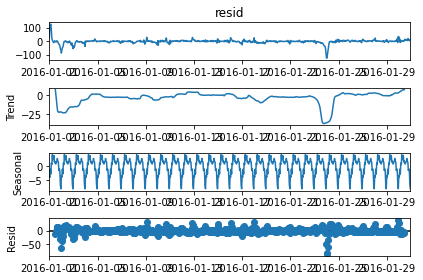

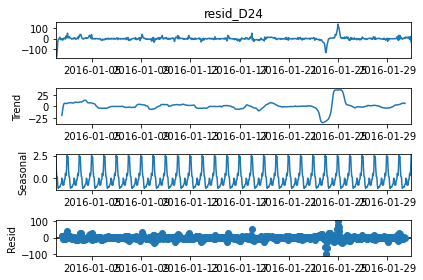

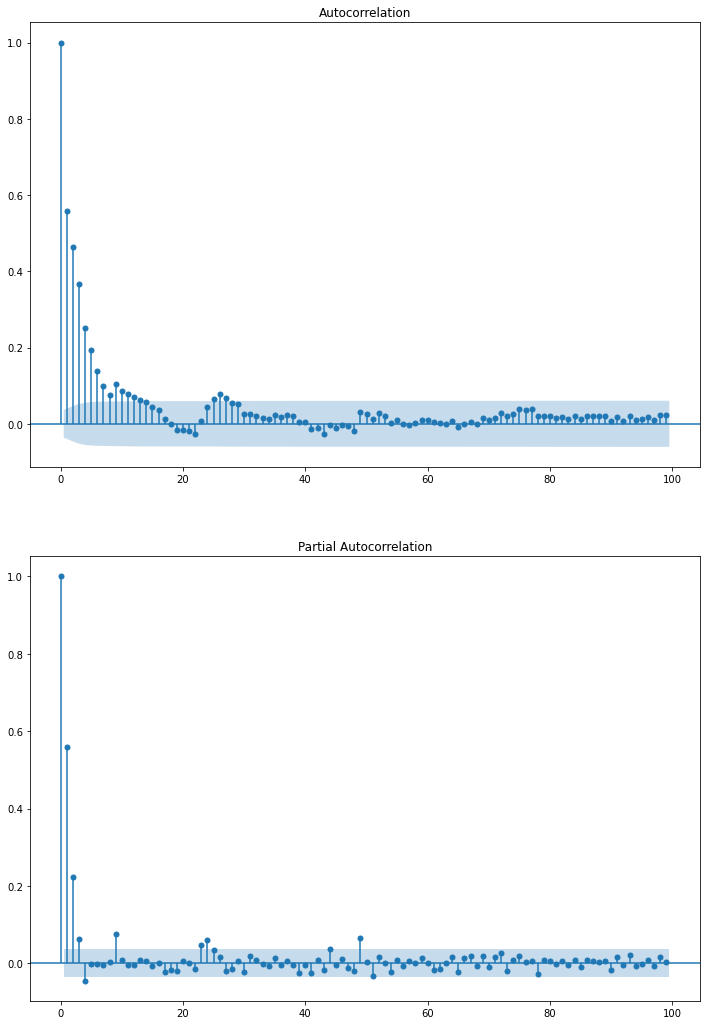

In [35]:
graph_analysis(clusters[0])

In [48]:
params0 = {'Q': 0,
           'q': 6,
           'P': 1,
           'p': 2}
d0 = 0
D0 = 0

parameters0 = list(product(range(params0['p']+1), range(params0['q']+1), range(params0['P']+1), range(params0['Q']+1)))
print(len(parameters0))

42


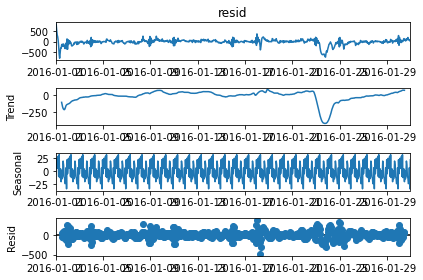

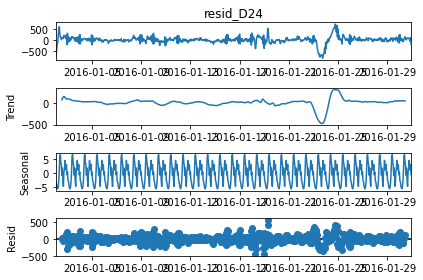

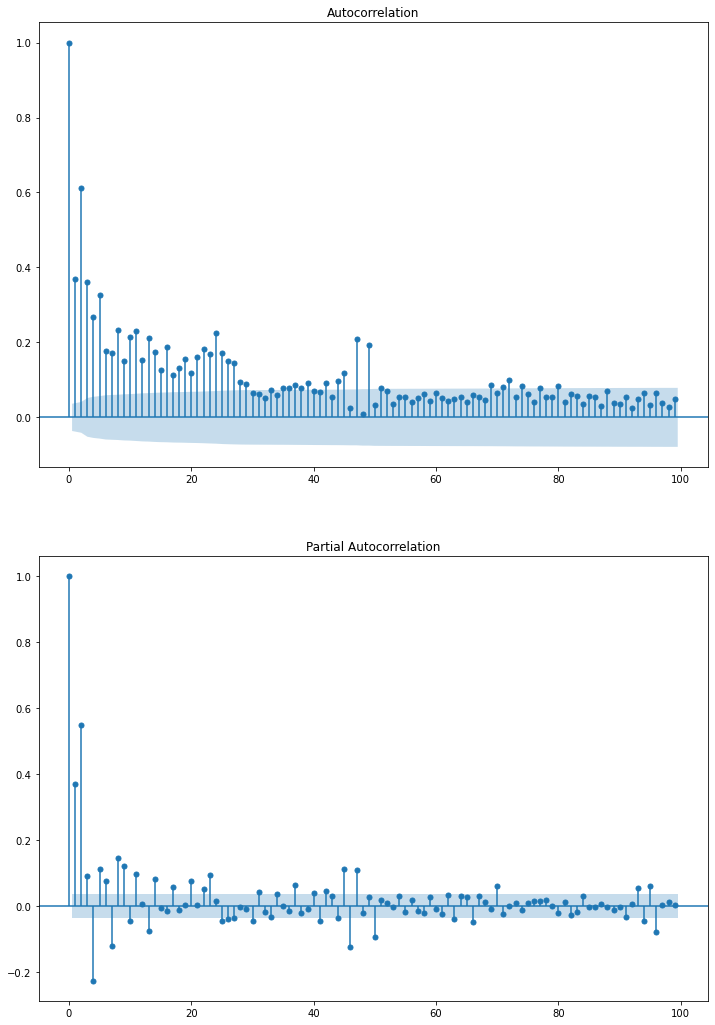

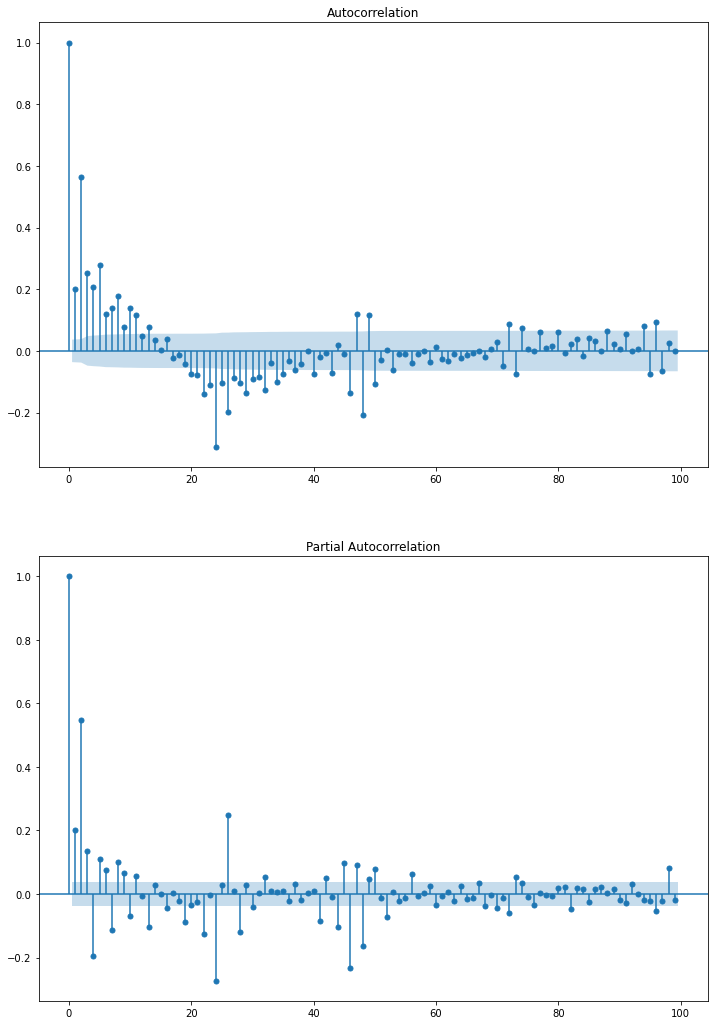

In [46]:
graph_analysis(clusters[1], show_seas=True)

In [13]:
params1 = {'Q': 1,
           'q': 2,
           'P': 1,
           'p': 2}

d1 = 0
D1 = 1

parameters1 = list(product(range(params1['p']+1), range(params1['q']+1), range(params1['P']+1), range(params1['Q']+1)))
print(len(parameters1))

36


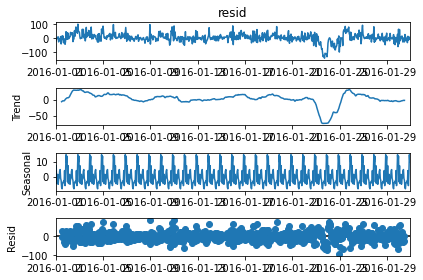

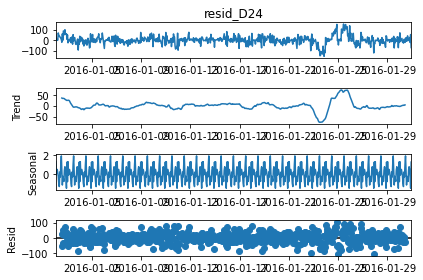

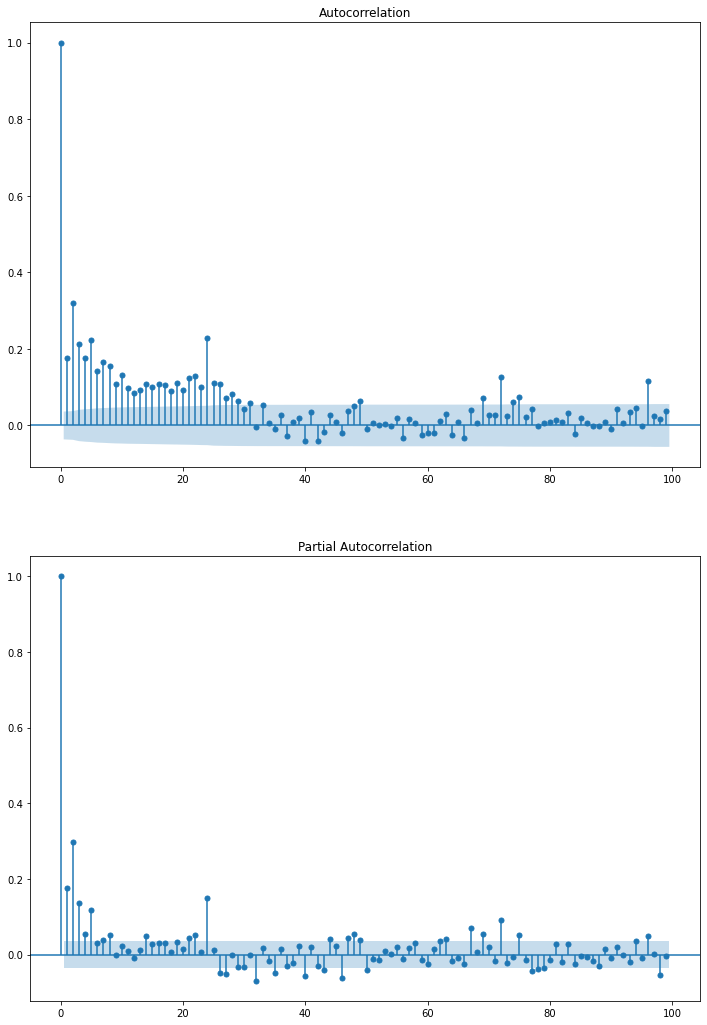

In [52]:
graph_analysis(clusters[2])

In [20]:
params2 = {'Q': 1,
           'q': 2,
           'P': 1,
           'p': 2}

d2 = 0
D2 = 0

parameters2 = list(product(range(params2['p']+1), range(params2['q']+1), range(params2['P']+1), range(params2['Q']+1)))
print(len(parameters2))

36


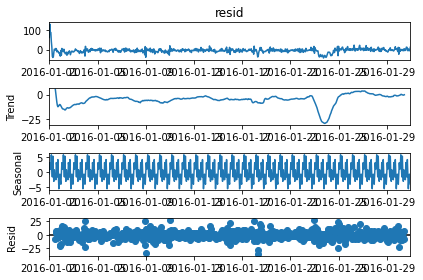

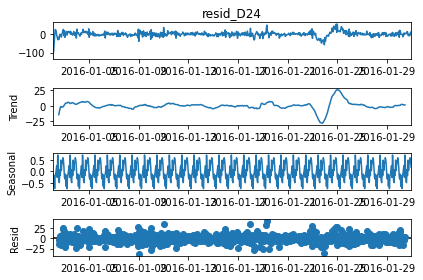

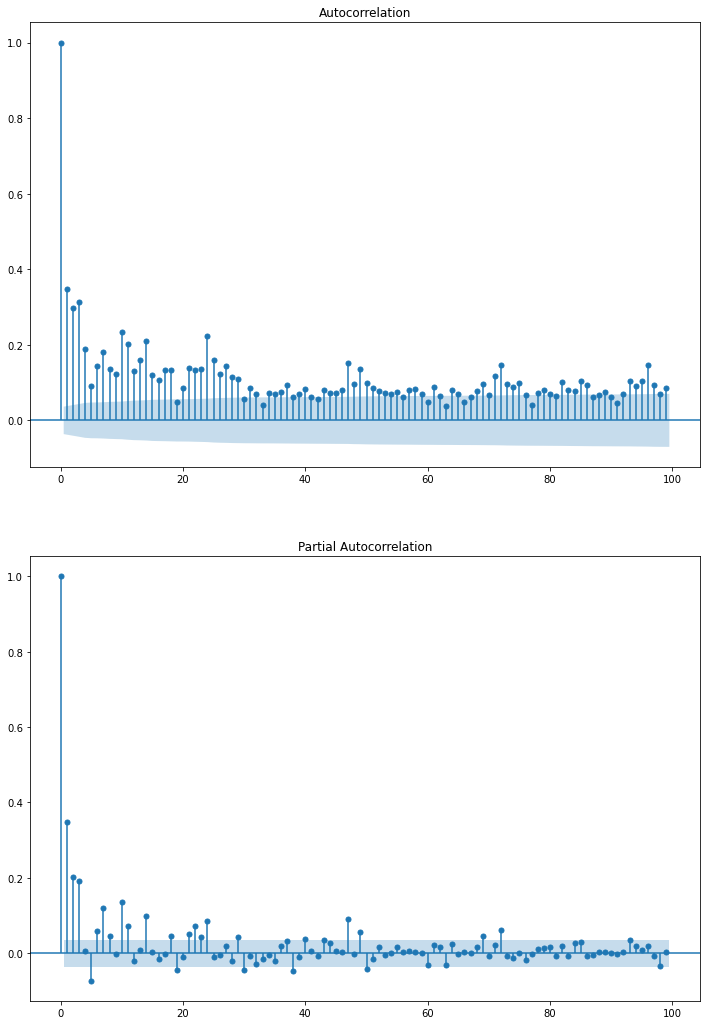

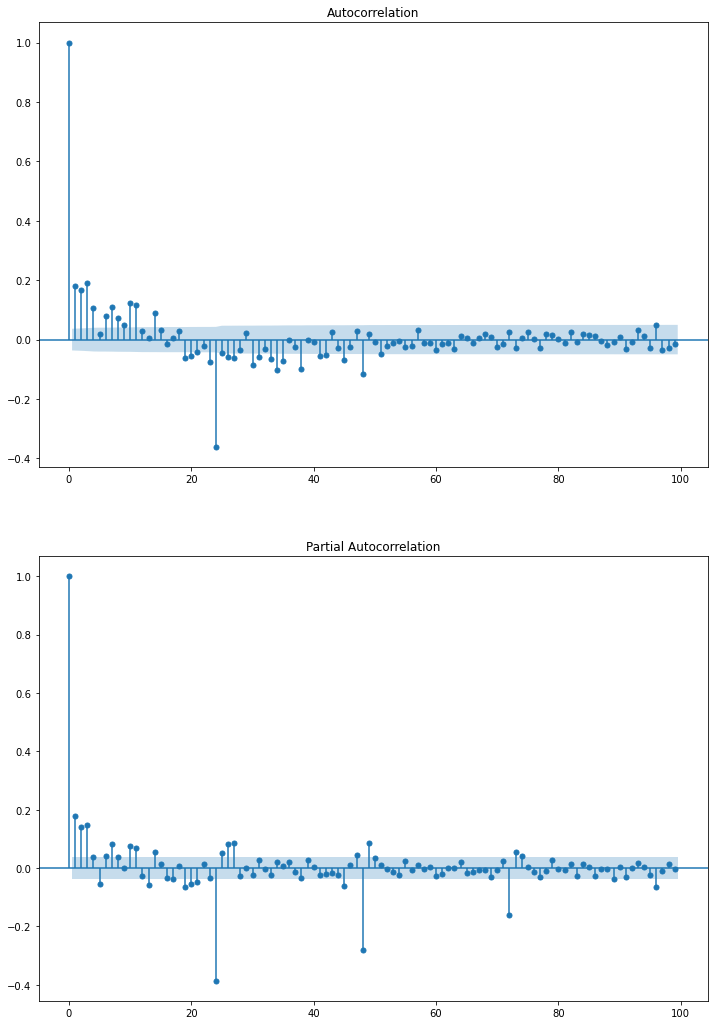

In [58]:
graph_analysis(clusters[3], show_seas=True)

In [59]:
params3 = {'Q': 1,
           'q': 3,
           'P': 1,
           'p': 3}

d3 = 0
D3 = 1

parameters3 = list(product(range(params3['p']+1), range(params3['q']+1), range(params3['P']+1), range(params3['Q']+1)))
print(len(parameters3))

64


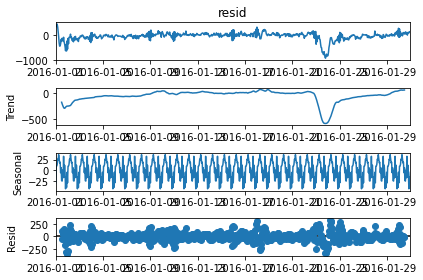

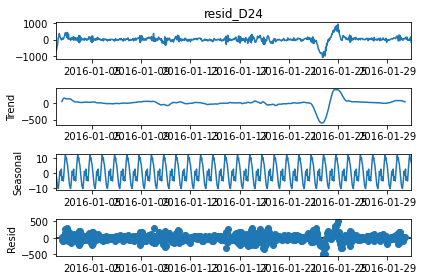

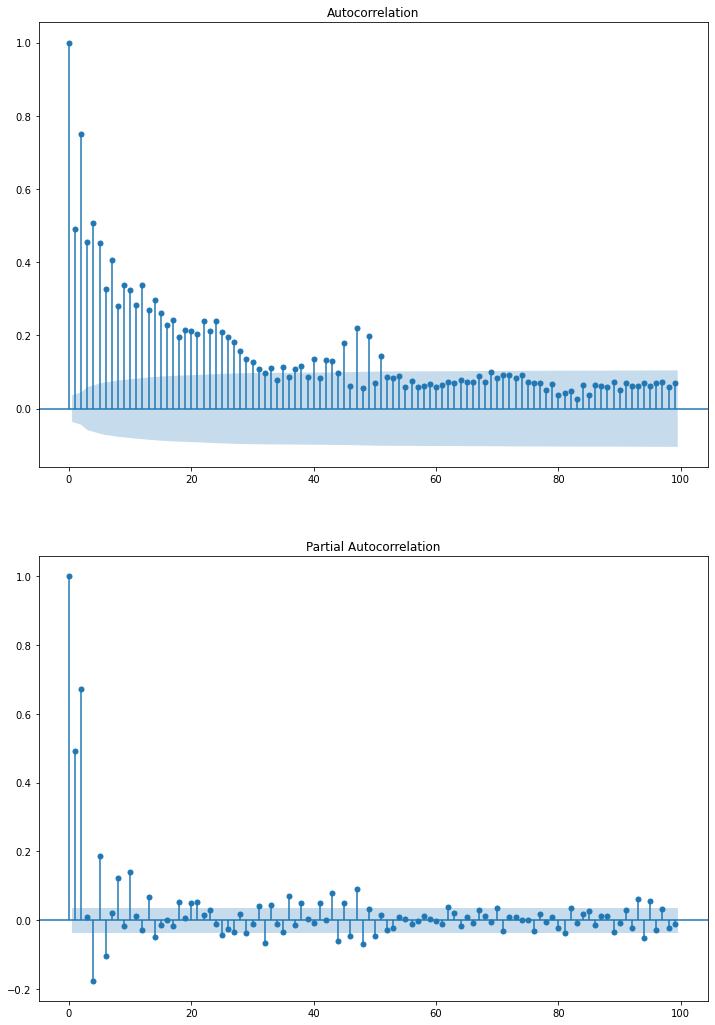

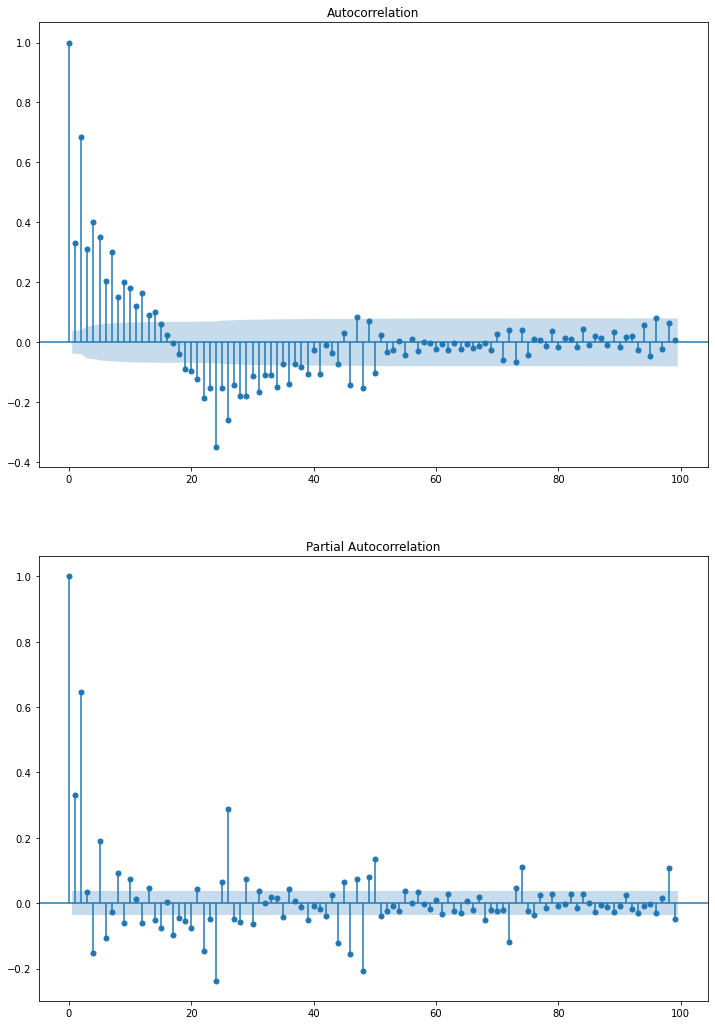

In [63]:
graph_analysis(clusters[4], show_seas=True)

In [64]:
params4 = {'Q': 1,
           'q': 2,
           'P': 1,
           'p': 2}

d4 = 0
D4 = 1

parameters4 = list(product(range(params4['p']+1), range(params4['q']+1), range(params4['P']+1), range(params4['Q']+1)))
print(len(parameters4))

36


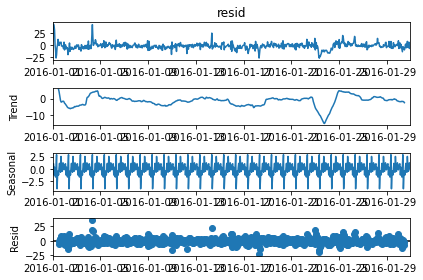

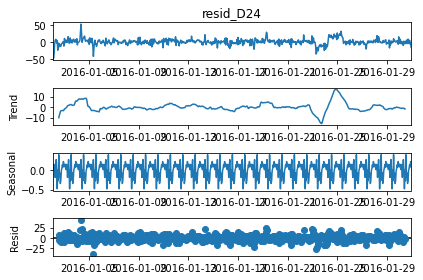

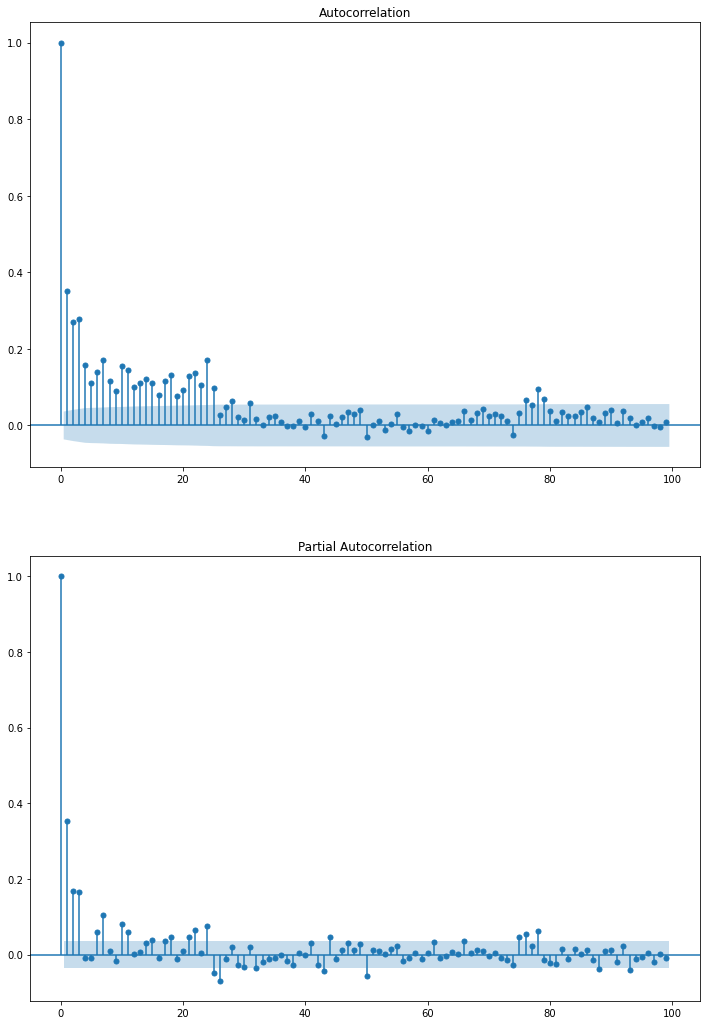

In [67]:
graph_analysis(clusters[5])

In [68]:
params5 = {'Q': 1,
           'q': 3,
           'P': 1,
           'p': 3}

d5 = 0
D5 = 0

parameters5 = list(product(range(params5['p']+1), range(params5['q']+1), range(params5['P']+1), range(params5['Q']+1)))
print(len(parameters5))

64


Для некоторых кластеров была идея использовать сезонное дифференцирование, однаков в дальнейшем от этого отказался, поскольку подбор параметров для 4/20 регинов внутри кластера занял более 10 часов. Поэтому решил смотреть без дифференцирования, параметры подобрал по графикам регрессионых остатков без дифференцирования.

Подбор параметров модели:

In [23]:
def sarimax_gridsearch(ts, exog, par, d=0, D=0, s=24, maxiter=35, freq='H'):
    '''
    Input: 
        ts : your time series data
        pdq : ARIMA combinations from above
        pdqs : seasonal ARIMA combinations from above
        maxiter : number of iterations, increase if your model isn't converging
        frequency : default='M' for month. Change to suit your time series frequency
            e.g. 'D' for day, 'H' for hour, 'Y' for year. 
        
    Return:
        Prints out top 5 parameter combinations
        Returns dataframe of parameter combinations ranked by AIC
    '''

    # Run a grid search with pdq and seasonal pdq parameters and get the best AIC value
    ans = []
    for (comb,j) in zip(par,range(len(par))):
        print(j)
        try:
            model = sm.tsa.statespace.SARIMAX(ts, exog,
                                                order=(comb[0],d,comb[1]),
                                                seasonal_order=(comb[2],D, comb[3],s),
                                                enforce_stationarity=False,
                                                enforce_invertibility=False,
                                                freq=freq)
            output = model.fit(maxiter=maxiter, method='nm', disp=-1)#, low_memory=True) 
            ans.append([comb,output.aic])
            print('SARIMAX {} x {}12 : AIC Calculated ={}'.format(comb, output.aic))
        except:
            continue
            
    # Find the parameters with minimal BIC value

    # Convert into dataframe
    ans_df = pd.DataFrame(ans, columns=['pqPQ', 'aic'])

    # Sort and return top 5 combinations
    ans_df = ans_df.sort_values(by=['aic'],ascending=True)[0:10]
    
    return ans_df

In [ ]:
%%time
sarimax_gridsearch(clusters[2]['2068'],clusters[2].drop('2068', axis=1), parameters2, D=0, d=0,freq='H')#timeseries - ваш временной ряд для представителя кластера 0

Обучение моделей и вычисление метрик (на примере двух кластеров, остальные считались в других местах). Для начала сохраним в отдельный файл названия регинов по кластерам и датасет по май включительно.

In [114]:
rnames = pd.read_csv('rnames.csv', dtype='str')

In [116]:
rnames

,0,1,2,3,4,5,6,7,8,9,...,17,18,19,20,21,22,23,24,25,26
0,1129,1130,1176,1177,1178,1221,1222,1223,1227,1228,...,1377,1378,1380,1426,1532,1533,NaN,NaN,NaN,NaN
1,1076,1077,1132,1181,1183,1184,1234,1235,1279,1280,...,1333,1334,1335,1336,1337,1383,1384,1385,1386,1434
2,1684,1733,1734,1783,2068,2069,2118,2119,2168,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,1172,1173,1174,1175,1182,1224,1225,1339,1387,1388,...,1439,1441,1442,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,1075,1125,1126,1127,1128,1131,1179,1180,1229,1230,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,1480,1482,1483,1530,1580,1630,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [117]:
reg0 = list(map(str, rnames.iloc[0][:23]))

temp = pd.read_csv('main_data_may.csv')
temp.index = temp.time
temp.drop('time', axis=1, inplace=True)

# здесь подбор параметров по которым иттерируюсь в ручную задан, но допустил ошибку, поэтому не посчитал метрику на некоторых часах, но переобучать уже не буду.
ind_last=3648
start_p = 2903
last_step = 738

In [4]:
%%time
r0_sum = 0
for reg in reg0:
    print(reg)
    data = get_final_dataset(temp[[reg]], f_num=51)

    model = sm.tsa.statespace.SARIMAX(data[reg][0 :ind_last],exog=data.drop(reg, axis=1)[0 :ind_last], order=(2, 0, 3),
                                       seasonal_order=(1, 0, 0, 24),
                                       enforce_stationarity=False,
                                       enforce_invertibility=False,freq='H').fit(disp=False)


    q_sum = 0
    for i in range(last_step):
        new_predict=model.get_prediction(start=start_p+i, end=start_p+i+5, dynamic=True,  exog=data.drop(reg, axis=1)[start_p+i:start_p+i+6]).predicted_mean

        q_sum += abs(new_predict - data[reg].iloc[start_p+i:start_p+i+6]).sum()
    print('q_sum:  ',q_sum)
    r0_sum+=q_sum

print('Regions0 sum:  ', r0_sum)

1129
q_sum:   202737.3492382192
1130
q_sum:   251747.88993615098
1176
q_sum:   21583.591517481156
1177
q_sum:   180043.08222746185
1178
q_sum:   250820.1933433938
1221
q_sum:   9993.996168291978
1222
q_sum:   14885.81567337438
1223
q_sum:   22275.944033057727
1227
q_sum:   110008.38255627562
1228
q_sum:   212372.55834901473
1272
q_sum:   12408.107221269034
1273
q_sum:   22149.76394186613
1274
q_sum:   11503.024620874548
1278
q_sum:   16095.593892759287
1326
q_sum:   26120.347872256414
1327
q_sum:   30473.64952484806
1376
q_sum:   16838.733828140917
1377
q_sum:   12501.116473438207
1378
q_sum:   11423.918844905229
1380
q_sum:   12274.672686657086
1426
q_sum:   9157.154967581666
1532
q_sum:   10524.317204322757
1533
q_sum:   13411.902671073576
Regions0 sum:   1481351.106792714
Wall time: 4h 44min 11s


In [6]:
reg1 = list(map(str, rnames.iloc[1][:27]))

In [8]:
%%time
r1_sum = 0
for reg in reg1:
    print(reg)
    data = get_final_dataset(temp[[reg]], f_num=61)

    model = sm.tsa.statespace.SARIMAX(data[reg][0 :ind_last],exog=data.drop(reg, axis=1)[0 :ind_last], order=(2, 0, 2),
                                       seasonal_order=(1, 0, 1, 24),
                                       enforce_stationarity=False,
                                       enforce_invertibility=False,freq='H').fit(disp=False)


    q_sum = 0
    for i in range(last_step):
        new_predict=model.get_prediction(start=start_p+i, end=start_p+i+5, dynamic=True,  exog=data.drop(reg, axis=1)[start_p+i:start_p+i+6]).predicted_mean

        q_sum += abs(new_predict - data[reg].iloc[start_p+i:start_p+i+6]).sum()
    print('q_sum:  ',q_sum)
    r1_sum+=q_sum

print('R1_sum:  ', r1_sum)

1076
q_sum:   83106.01243349894
1077
q_sum:   60639.16829644509
1132
q_sum:   64981.30633451965
1181
q_sum:   406504.1606127055
1183
q_sum:   93716.70973681977
1184
q_sum:   20099.61648809864
1234
q_sum:   186568.2316086075
1235
q_sum:   88087.4881439624
1279
q_sum:   26869.731377033375
1280
q_sum:   104944.37111620451
1283
q_sum:   138516.07906844057
1284
q_sum:   60936.19802602961
1285
q_sum:   137113.8505384629
1286
q_sum:   116487.43559201572
1287
q_sum:   49301.358582967725
1331
q_sum:   35241.55470941037
1332
q_sum:   171068.68782040768
1333
q_sum:   256618.41168075785
1334
q_sum:   239594.02716304056
1335
q_sum:   76093.45032543337
1336
q_sum:   43077.554924290635
1337
q_sum:   51804.87942368728
1383
q_sum:   137317.21690786755
1384
q_sum:   224687.17132996372
1385
q_sum:   133764.87435651815
1386
q_sum:   32307.67345478849
1434
q_sum:   12738.706547123213
R1_sum:   3052185.9265991007
Wall time: 6h 45min 54s


In [9]:
R0_sum = 481351.106792714
R1_sum = 3052185.9265991007
R2_sum = 678263.1218532635
R3_sum = 610787.8432948651
R4_sum = 3528214.485929025
R5_sum = 74573.17930143779

Значение итоговой метрики за май:

In [10]:
Q_may = (R0_sum+R1_sum+R2_sum+R3_sum+R4_sum+R5_sum)/(102*739*6)

In [11]:
Q_may

18.629166033790597

In [26]:
rnames = pd.read_csv('rnames.csv', dtype='str')
reg1 = list(map(str, rnames.iloc[1][:27]))
reg2 = list(map(str, rnames.iloc[2][:9]))

temp = pd.read_csv('main_data_june.csv')
temp.index = temp.time
temp.drop('time', axis=1, inplace=True)

# здесь подбор параметров по которым иттерируюсь в ручную задан, но допустил ошибку, поэтому не посчитал метрику на некоторых часах, но переобучать уже не буду.
ind_last_j = 4368
start_p_june = 3648
last_step_j = 715

In [21]:
%%time
df = pd.DataFrame(columns=['id', 'y'])
r1_sum = 0
for reg in reg1:
    print(reg)
    data = get_final_dataset(temp[[reg]], f_num=61)

    model = sm.tsa.statespace.SARIMAX(data[reg][0 :ind_last_j],exog=data.drop(reg, axis=1)[0 :ind_last_j], order=(2, 0, 2),
                                       seasonal_order=(1, 0, 1, 24),
                                       enforce_stationarity=False,
                                       enforce_invertibility=False,freq='H').fit(disp=False)

    q_sum = 0
    for i in range(last_step_j):
        new_predict=model.get_prediction(start=start_p_june+i, end=start_p_june+i+5, dynamic=True,  exog=data.drop(reg, axis=1)[start_p_june+i:start_p_june+i+6]).predicted_mean
        
        ids=[]
        k=1
        for t in new_predict.index:
            _ = reg+'_'+str(t)[:10]+'_'+str(t.hour)+'_'+str(k)
            k+=1
            ids.append(_)
    
        tdf = pd.DataFrame({'id': ids, 'y':new_predict}).reset_index(drop=True)
        df = pd.concat([df, tdf])

        q_sum += abs(new_predict - data[reg].iloc[start_p_june+i:start_p_june+i+6]).sum()
    print('q_sum:  ',q_sum)
    r1_sum+=q_sum
    
    
    all_pred=model.get_prediction(dynamic=False, 
                                     exog=data.drop(reg, axis=1)).predicted_mean
    all_pred.to_csv('models/'+reg+'_model.csv')
    
df.reset_index(drop=True)
df.to_csv('R1_pred.csv', index=False)
print('R1_sum:  ', r1_sum)

1076
q_sum:   75109.3553431456
1077
q_sum:   54031.39459572969
1132
q_sum:   59585.47970798392
1181
q_sum:   347828.17008087575
1183
q_sum:   84341.21203795365
1184
q_sum:   17863.17216919858
1234
q_sum:   169592.08797287292
1235
q_sum:   84634.34810331916
1279
q_sum:   24552.556320361746
1280
q_sum:   106316.09970379446
1283
q_sum:   130739.14654899966
1284
q_sum:   60506.3100314362
1285
q_sum:   138321.06902032625
1286
q_sum:   115264.3905884444
1287
q_sum:   47135.871199031855
1331
q_sum:   29461.68355257783
1332
q_sum:   152245.15187520796
1333
q_sum:   234326.6244091967
1334
q_sum:   225374.72279993334
1335
q_sum:   69478.82259279204
1336
q_sum:   44604.28425054886
1337
q_sum:   48198.090274055525
1383
q_sum:   113205.45227693093
1384
q_sum:   200840.78376393561
1385
q_sum:   128022.83581786518
1386
q_sum:   32494.20359366767
1434
q_sum:   11080.133206288096
R1_sum:   2805153.451836474
Wall time: 9h 22min 8s


In [23]:
reg3 = list(map(str, rnames.iloc[3][:20]))

In [26]:
%%time
df = pd.DataFrame(columns=['id', 'y'])
r3_sum = 0
for reg in reg3:
    print(reg)
    data = get_final_dataset(temp[[reg]], f_num=45)

    model = sm.tsa.statespace.SARIMAX(data[reg][0 :ind_last_j],exog=data.drop(reg, axis=1)[0 :ind_last_j], order=(3, 0, 3),
                                       seasonal_order=(1, 0, 1, 24),
                                       enforce_stationarity=False,
                                       enforce_invertibility=False,freq='H').fit(disp=False)


    q_sum = 0
    for i in range(last_step_j):
        new_predict=model.get_prediction(start=start_p_june+i, end=start_p_june+i+5, dynamic=True,  exog=data.drop(reg, axis=1)[start_p_june+i:start_p_june+i+6]).predicted_mean

        ids=[]
        k=1
        for t in new_predict.index:
            _ = reg+'_'+str(t)[:10]+'_'+str(t.hour)+'_'+str(k)
            k+=1
            ids.append(_)
    
        tdf = pd.DataFrame({'id': ids, 'y':new_predict}).reset_index(drop=True)
        df = pd.concat([df, tdf])

        q_sum += abs(new_predict - data[reg].iloc[start_p_june+i:start_p_june+i+6]).sum()
    print('q_sum:  ',q_sum)
    r3_sum+=q_sum
    all_pred=model.get_prediction(dynamic=False, 
                                     exog=data.drop(reg, axis=1)).predicted_mean
    all_pred.to_csv('models0/'+reg+'_model.csv')

df.reset_index(drop=True)
df.to_csv('R3_pred.csv', index=False)
print('Regions sum:  ', r3_sum)

1172
q_sum:   9261.077223724387
1173
q_sum:   23022.73538521813
1174
q_sum:   26827.595654492536
1175
q_sum:   15218.27782307081
1182
q_sum:   213379.73585159733
1224
q_sum:   24126.21638219906
1225
q_sum:   9891.361381565606
1339
q_sum:   13559.025004984602
1387
q_sum:   28806.7776736425
1388
q_sum:   22723.648403259365
1389
q_sum:   16991.731116762905
1390
q_sum:   17911.26553595655
1431
q_sum:   20967.206875883596
1435
q_sum:   12662.848647448169
1436
q_sum:   25171.86946318321
1437
q_sum:   34949.933389830585
1438
q_sum:   13801.58661038251
1439
q_sum:   10647.701520942881
1441
q_sum:   8315.967079696895
1442
q_sum:   11531.734600433005
Regions sum:   559768.2956242746
Wall time: 5h 15min 31s


In [1]:
R0_sum_j = 1243852.8359925079
R1_sum_j = 2805153.451836474
R2_sum_j = 668094.2118062971
R3_sum_j = 559768.2956242746
R4_sum_j = 3141015.1866915273 
R5_sum_j = 68793.81741966453 

Значение итоговой метрики за июнь:

In [3]:
Q_june = (R0_sum_j+R1_sum_j+R2_sum_j+R3_sum_j+R4_sum_j+R5_sum_j)/(102*715*6)

In [4]:
Q_june

19.394574247842097

In [109]:
R0_j = pd.read_csv('R0_pred.csv')
R1_j = pd.read_csv('R1_pred.csv')
R2_j = pd.read_csv('R2_pred.csv')
R3_j = pd.read_csv('R3_pred.csv')
R4_j = pd.read_csv('R4_pred.csv')
R5_j = pd.read_csv('R5_pred.csv')

In [110]:
df = pd.concat([R0_j, R1_j, R2_j, R3_j, R4_j, R5_j])

In [112]:
submission0 = pd.concat([R0_j, R1_j, R2_j, R3_j, R4_j, R5_j]).sort_values('id').reset_index(drop=True)
submission0.head()

,id,y
0,1075_2016-05-31_23_1,27.324203
1,1075_2016-05-31_23_2,5.408753
2,1075_2016-05-31_23_3,1.561261
3,1075_2016-05-31_23_4,-2.379892
4,1075_2016-05-31_23_5,-0.575803


In [113]:
submission0.to_csv('submissions0.csv', index=False)